In [1]:
import os
import logging
import collections
import datetime

import gpflow
import tensorflow as tf
import numpy as np
import pandas as pd

import sklearn as sk
import sklearn.model_selection
import sklearn.neighbors
import scipy.io as sio

import IPython.display as ipd
import matplotlib as mpl
import matplotlib.pyplot as plt

import GP.kernels as kernels
from GP.expectations import analyticExpectation, gaussHermiteExpectation, unscentedExpectation, montecarloExpectation
from GP.models import GPLVM

%matplotlib inline

opt = gpflow.train.ScipyOptimizer()

tf.logging.set_verbosity(tf.logging.FATAL)
gpflow.logdensities.logger.setLevel(logging.CRITICAL)
np.random.seed(42)
tf.random.set_random_seed(42)

In [2]:
def visualize_scatter_with_images(X, images, ax, image_zoom=1, hide_overlaps=True, color=(1,1,1), drawn_boxes=None):
    wh = None
    drawn_boxes = drawn_boxes or []
    drawn_indices = []
    r,g,b = color
    
    ax.update_datalim(X)
    ax.autoscale()
    for xy, i in zip(X, images):
        img = mpl.offsetbox.OffsetImage(np.clip(np.dstack([(1-i)*r, (1-i)*g, (1-i)*b, i]),0,1), zoom=image_zoom)
        abbox = mpl.offsetbox.AnnotationBbox(img, xy, xycoords='data', frameon=False)
        
        if wh is not None:
            bb = mpl.transforms.Bbox.from_bounds(*(xy-wh/2), *wh)
#             ax.add_patch(mpl.patches.Rectangle(bb.bounds[0:2], *bb.bounds[2:]))
            if hide_overlaps and bb.count_overlaps(drawn_boxes) > 0:
                drawn_indices.append(False)
                continue
        
        ax.add_artist(abbox)
        
        if wh is None:
            ax.figure.canvas.draw()
            a = (curr_axis.transData.inverted().transform(abbox.get_children()[1].get_bbox()))
            wh = np.array([a[1,0]-a[0,0], a[1,1]-a[0,1]])
            bb = mpl.transforms.Bbox.from_bounds(*(xy-wh/2), *wh)
        drawn_boxes.append(bb)
        drawn_indices.append(True)
    return np.array(drawn_indices), drawn_boxes
    
def kernel_name(k):
    if type(k) is gpflow.kernels.Sum:
        return '+'.join([kernel_name(k) for k in k.kernels])
    if type(k).__name__ == 'MLP':
        return f'MLP{k.layers}'
    else:
        return type(k).__name__

In [3]:
save_or_load = 'save'
dataset = 'oil flow'

In [4]:
dataset_path_friendly = dataset.replace(' ','_')
if save_or_load not in ['save','load','rerun','loadsave']:
    raise Exception(f'Invalid operation {save_or_load}')
if dataset == 'oil flow':
    data = np.load('data/three_phase_oil_flow.npz')
    Y = data['Y']
    labels = data['labels']
elif dataset == 'USPS digits':
    data = sio.loadmat('data/usps_all.mat')
    N = 300
    Y = data['data'][:,0:N,[0,1,2,3,9]].T.reshape(-1,256)/256
    del data
    labels = np.array([x for x in [1,2,3,4,0] for _ in range(0,N)])
    digit_images = np.array([y.reshape(16,16).T for y in Y])
elif dataset == 'USPS digits all':
    data = sio.loadmat('data/usps_all.mat')
    N = 500
    Y = data['data'][:,0:N,:].T.reshape(-1,256)/256
    del data
    labels = np.array([x for x in [1,2,3,4,5,6,7,8,9,0] for _ in range(0,N)])
    digit_images = np.array([y.reshape(16,16).T for y in Y])
else:
    raise Exception(f'Unknown Dataset {dataset}')

In [5]:
if save_or_load in ['save','rerun']:
    Q = 5 # latent dimension
    M = 20  # number of inducing pts
    N = Y.shape[0] # Number of outputs
    hermite_points = 2
    montecarlo_runs = 10

    X_mean = gpflow.models.PCA_reduce(Y, Q) # Initialise via PCA
    Z = np.random.permutation(X_mean.copy())[:M]
    opt = gpflow.train.ScipyOptimizer()
    
    if dataset == 'oil flow':
        parameters = [
            (gpflow.kernels.RBF(Q, ARD=True), analyticExpectation),
            
            (gpflow.kernels.RBF(Q, ARD=True), unscentedExpectation),
            (gpflow.kernels.RBF(Q, ARD=True), gaussHermiteExpectation(hermite_points)),
            (lambda: gpflow.kernels.RBF(Q, ARD=True), montecarloExpectation(2*Q), montecarlo_runs),
            (lambda: gpflow.kernels.RBF(Q, ARD=True), montecarloExpectation(hermite_points**Q), montecarlo_runs),
            
            (gpflow.kernels.Matern32(Q, ARD=True), unscentedExpectation),
            (gpflow.kernels.Matern32(Q, ARD=True), gaussHermiteExpectation(hermite_points)),
            (lambda: gpflow.kernels.Matern32(Q, ARD=True), montecarloExpectation(2*Q), montecarlo_runs),
            (lambda: gpflow.kernels.Matern32(Q, ARD=True), montecarloExpectation(hermite_points**Q), montecarlo_runs),
        ]
    elif dataset == 'USPS digits' or dataset == 'USPS digits all':
        MLP = kernels.MLP(2,[30,60])
        parameters = [
            (gpflow.kernels.RBF(Q, ARD=True), analyticExpectation),
            
            (gpflow.kernels.RBF(Q, ARD=True), unscentedExpectation),
            (gpflow.kernels.RBF(Q, ARD=True), gaussHermiteExpectation(hermite_points)),
            (lambda: gpflow.kernels.RBF(Q, ARD=True), montecarloExpectation(2*Q), montecarlo_runs),
            (lambda: gpflow.kernels.RBF(Q, ARD=True), montecarloExpectation(hermite_points**Q), montecarlo_runs),
            
            (MLP.clone(), unscentedExpectation),
            (MLP.clone(), gaussHermiteExpectation(hermite_points)),
            (lambda: MLP.clone(), montecarloExpectation(2*Q), montecarlo_runs),
            (lambda: MLP.clone(), montecarloExpectation(hermite_points**Q), montecarlo_runs),
        ]

    gplvms_by_name = collections.OrderedDict()
    for parameter in parameters:
        if len(parameter) == 2:
            kernel, expectation = parameter
            m = GPLVM(expectation, X_mean=X_mean.copy(), X_var=0.1*np.ones((N, Q)), Y=Y,kern=kernel, M=len(Z), Z=Z.copy())
            m.likelihood.variance = 0.01
            gplvms_by_name[(expectation.__name__,kernel_name(kernel), 0)] = m
        else:
            kernel, expectation, runs = parameter
            for run in range(runs):
                m = GPLVM(expectation, X_mean=X_mean.copy(), X_var=0.1*np.ones((N, Q)), Y=Y,kern=kernel(), M=len(Z), Z=Z.copy())
                m.likelihood.variance = 0.01
                gplvms_by_name[(expectation.__name__,kernel_name(m.kern), run)] = m

    columns = [('analytic','PCA',0), *gplvms_by_name.keys()]
    
    # Fit GPLVMs
    bar = ipd.ProgressBar(len(gplvms_by_name))
    ipd.display(ipd.HTML('<h4>Progress:</h4>'))
    bar.display()

    tf.logging.set_verbosity(tf.logging.ERROR)
    for key, model in gplvms_by_name.items():
        print(key,'@',datetime.datetime.now().strftime("%I:%M %p"))
        if 'montecarlo' in key[0]:
#             %time gpflow.training.RMSPropOptimizer(0.001).minimize(model, maxiter=5000)
#             %time gpflow.training.AdamOptimizer(0.001).minimize(model, maxiter=5000)
            %time opt.minimize(model, maxiter=5000)
        else:
#             %time gpflow.training.AdamOptimizer(0.001).minimize(model, maxiter=5000)
            %time opt.minimize(model, maxiter=5000)
        bar.progress += 1
    tf.logging.set_verbosity(tf.logging.INFO)
    print('Finished @', datetime.datetime.now().strftime("%I:%M %p"))

In [6]:
if save_or_load in ['save','rerun']:
    latent_space = pd.DataFrame(
        index=range(len(Y)),
        columns=pd.MultiIndex.from_tuples(
            ((*column, m, i) for column in columns for m in ['mean', 'variance'] for i in range(2) if not (column[1] == 'PCA' and m == 'variance')),
            names=['method', 'kernel', 'run', 'stat', 'dim']
        ),
        dtype=float
    ).sort_index(axis=1)

    latent_space.loc[:, ('analytic','PCA', 0, 'mean')] = gpflow.models.PCA_reduce(Y, 2)
    for key, model in gplvms_by_name.items():
        kern = model.kern
        if isinstance(kern, gpflow.kernels.Combination):
            kern = kern.kernels[0]
        if type(kern) is kernels.MLP:
            dim1, dim2 = 0,1
        else:
            sens = np.sqrt(kern.variance.read_value())/kern.lengthscales.read_value()
            dim1, dim2 = sens.argsort()[::-1][:2]
        X_mean = model.X_mean.read_value()
        X_var  = model.X_var.read_value()
        latent_space[(*key, 'mean')] = X_mean[:, [dim1,dim2]]
        latent_space[(*key, 'variance')] = X_var[:, [dim1,dim2]]
        if save_or_load == 'save':
            os.makedirs("./points", exist_ok=True)
            latent_space.to_hdf(f'./points/{dataset_path_friendly}.hdf', key='points')
elif save_or_load in ['load', 'loadsave']:
    latent_space = pd.read_hdf(f'./points/{dataset_path_friendly}.hdf', key='points')
    columns = latent_space.columns.droplevel(['stat','dim']).drop_duplicates()

In [7]:
def expected_squared_euclidian_distance(x,y):
    x_mean, x_var = x[[0,1]], x[[2,3]]
    y_mean, y_var = y[[0,1]], x[[2,3]]
    return np.sum((y_mean-x_mean)**2 + x_var + y_var)

def kullback_leiber_divergence(x,y):
    d = 2
    x_mean, x_var = x[[0,1]], x[[2,3]]
    y_mean, y_var = y[[0,1]], x[[2,3]]
    
    trace = np.sum(1/y_var * x_var)
    mahalanobis_term = np.sum(1/y_var * (y_mean-x_mean)**2)
    log_term = np.prod(y_var)/np.prod(x_var)
    
    return 0.5 * (trace + mahalanobis_term + np.log(log_term) - d)

def symmetric_kl(x,y):
    return kullback_leiber_divergence(x,y) + kullback_leiber_divergence(y,x)

metrics = {
    'minkowski': 'minkowski',
#     'expected square euclidian distance': expected_squared_euclidian_distance,
#     'symmetric kullback-leiber divergence': symmetric_kl
}

In [8]:
folds = 5

accuracy = pd.DataFrame(
    index=pd.RangeIndex(folds, name='fold'),
    columns=pd.MultiIndex.from_tuples((
        (metric,*column)
        for column in columns
        for metric in metrics
        if not metric != 'minkowski' or column[1] != 'PCA'
    ), names=['metric', 'expectation', 'kernel', 'run']),
    dtype=float
).sort_index(axis=1)

missed = pd.DataFrame(
    index=pd.MultiIndex.from_product([range(folds), range(len(Y))], names=['fold', None]),
    columns=accuracy.columns,
    dtype=bool
).sort_index(axis=1)

In [9]:
bar = ipd.ProgressBar(len(metrics))
ipd.display(ipd.HTML('<h4>Progress:</h4>'))
bar.display()
for metric_name, metric in metrics.items():
    print(metric_name, '@', datetime.datetime.now().strftime("%I:%M %p"))
    kf = sk.model_selection.KFold(folds, shuffle=True, random_state=42)
    for i, (trainIdx, testIdx) in enumerate(kf.split(labels)):
        y_train, y_test = labels[trainIdx], labels[testIdx]
        for column in columns:
            if (metric_name, *column) not in accuracy.columns:
                continue
            
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=1, metric=metric)
            
            if metric_name == 'minkowski':
                train, test = latent_space.loc[trainIdx,(*column, 'mean')], latent_space.loc[testIdx,(*column, 'mean')]
            else:
                train, test = latent_space.loc[trainIdx,column], latent_space.loc[testIdx,column]
            knn.fit(train, y_train)
            if metric_name == 'minkowski':
                predicted_labels = knn.predict(latent_space[(*column, 'mean')])
            else:
                predicted_labels = knn.predict(latent_space[column])
            missed.loc[pd.IndexSlice[i,:],(metric_name, *column)] = (labels != predicted_labels)
            y_pred = knn.predict(test)
            accuracy.at[i,(metric_name, *column)] = sk.metrics.accuracy_score(y_test, y_pred)
    bar.progress += 1
if save_or_load in ['save', 'loadsave']:
    os.makedirs("./tabs/", exist_ok=True)
    (accuracy.stack('run').describe().loc[['mean','std']] * 100).T.to_csv(f"./tabs/acc_{dataset_path_friendly}_mean.csv")
    accuracy.to_csv(f"./tabs/acc_{dataset_path_friendly}.csv")

print('Finished @', datetime.datetime.now().strftime("%I:%M %p"))
ipd.display((accuracy.stack('run').describe().loc[['mean','std']] * 100).T)

[============================================================] 1/1

minkowski @ 05:02 PM
Finished @ 05:02 PM


mean       std
metric    expectation    kernel                            
minkowski analytic       PCA                 79.0  6.519202
                         SquaredExponential  98.0  2.738613
          montecarlo(10) SquaredExponential  96.2  3.434519
          unscented      SquaredExponential  98.0  2.738613

analytic_PCA_0


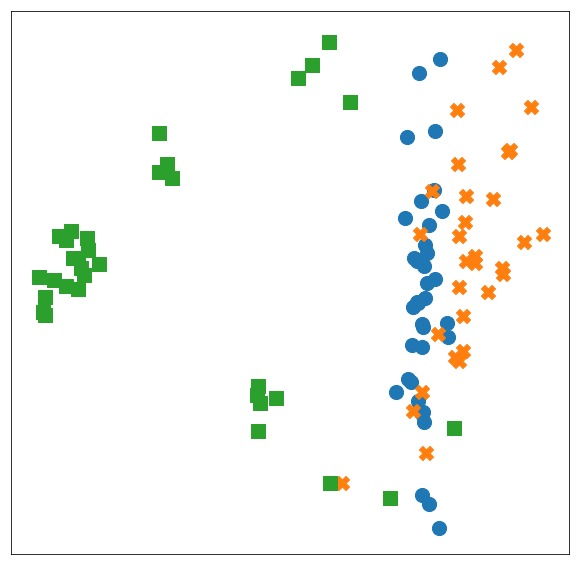

analytic_SquaredExponential_0


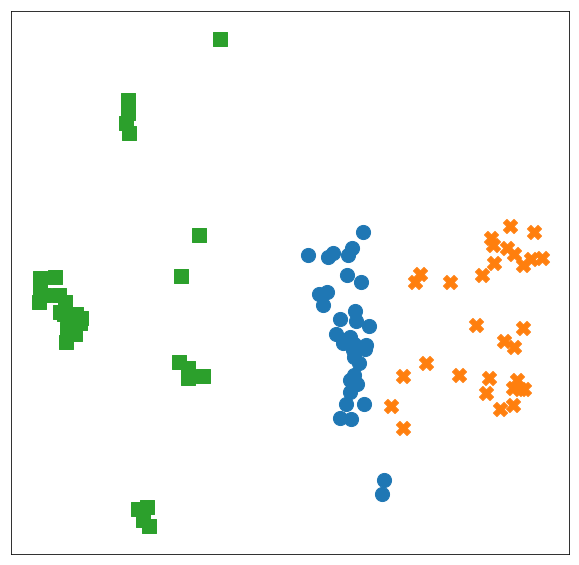

montecarlo(10)_SquaredExponential_0


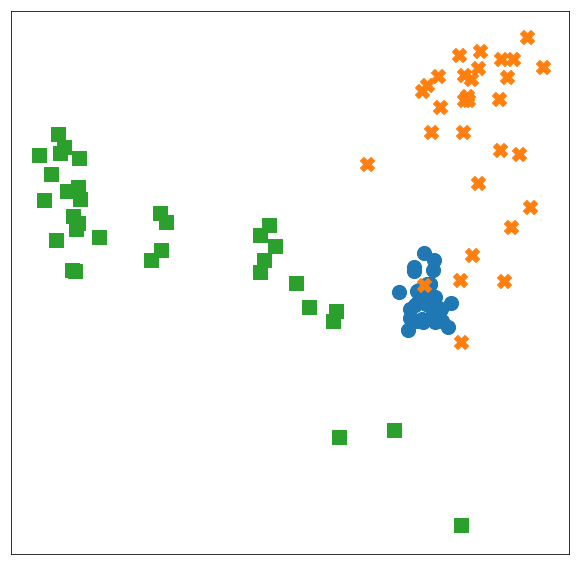

montecarlo(10)_SquaredExponential_1


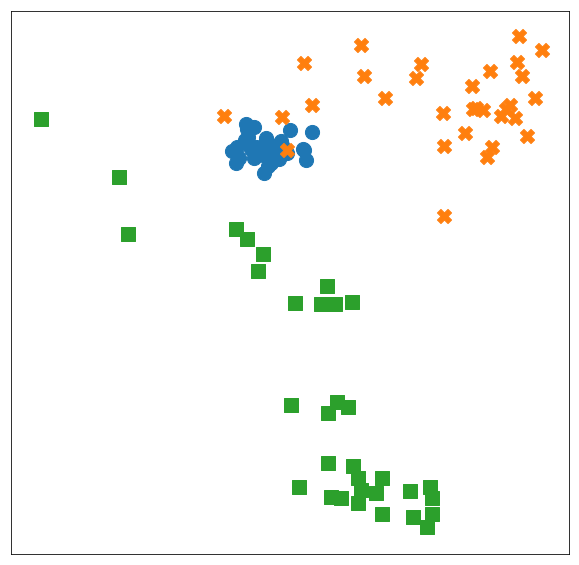

montecarlo(10)_SquaredExponential_2


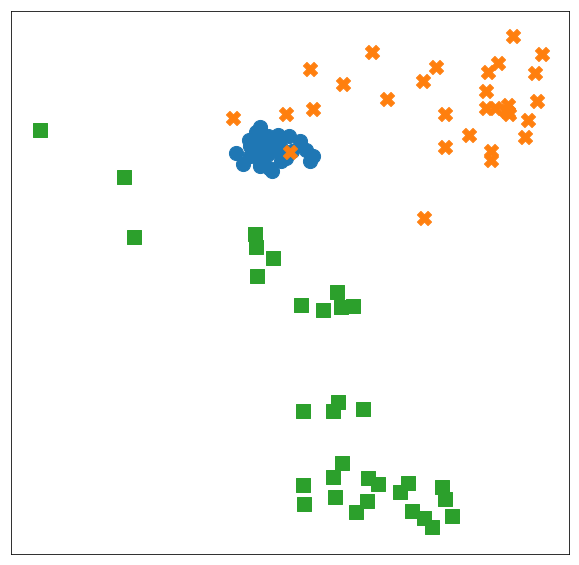

montecarlo(10)_SquaredExponential_3


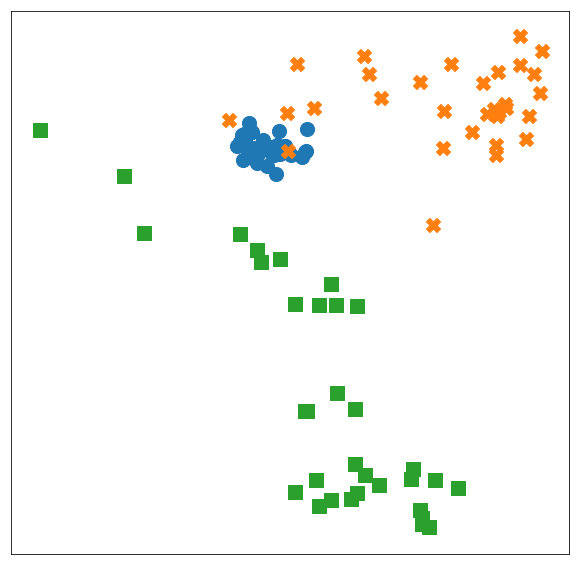

montecarlo(10)_SquaredExponential_4


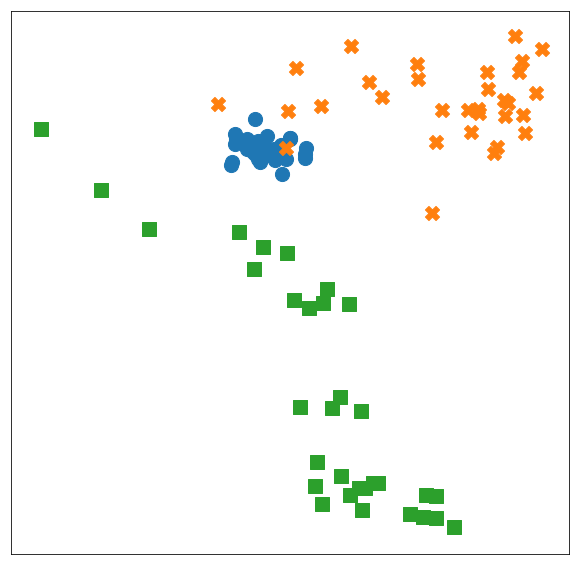

montecarlo(10)_SquaredExponential_5


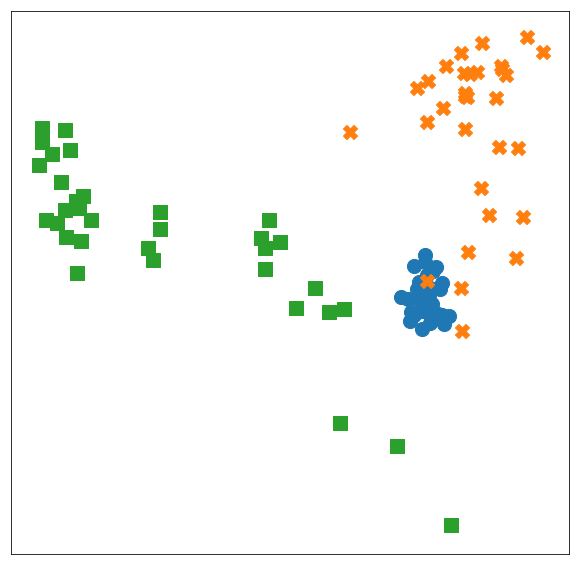

montecarlo(10)_SquaredExponential_6


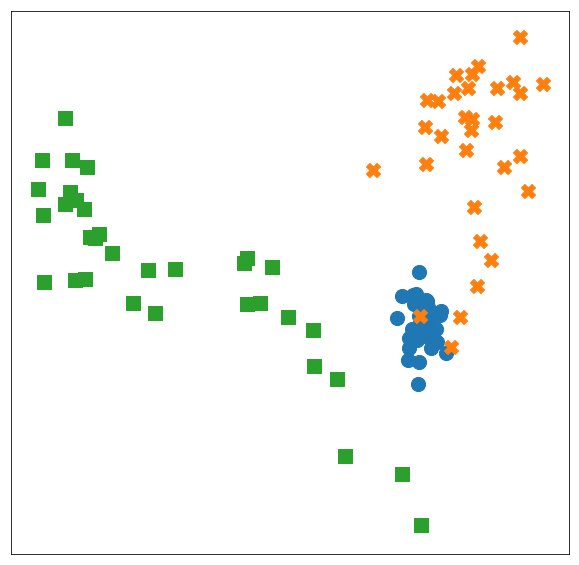

montecarlo(10)_SquaredExponential_7


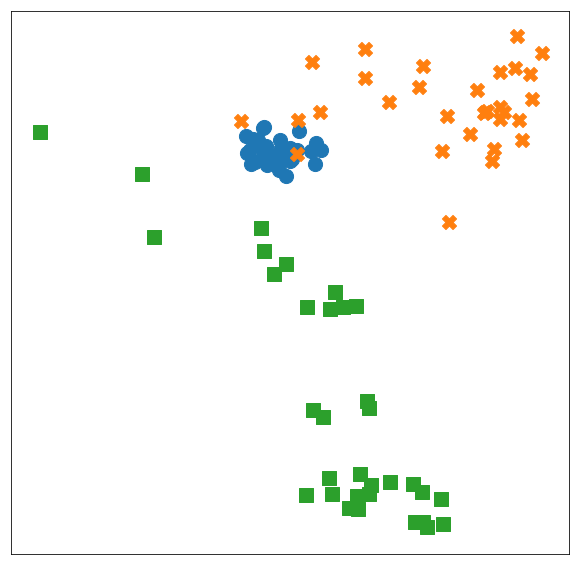

montecarlo(10)_SquaredExponential_8


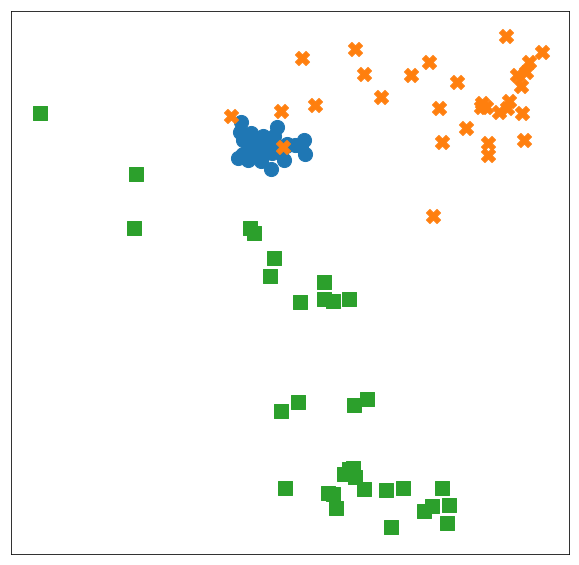

montecarlo(10)_SquaredExponential_9


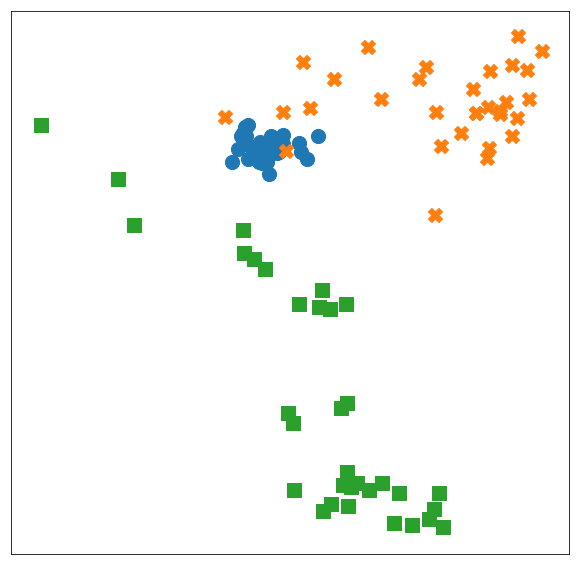

unscented_SquaredExponential_0


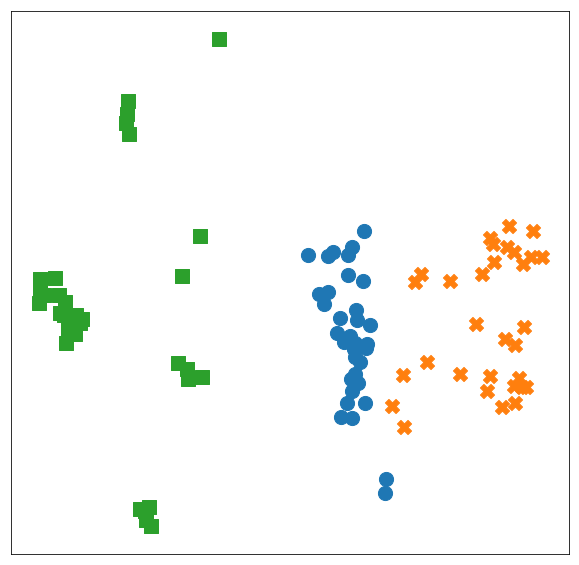

In [10]:
# Plots
colors = plt.get_cmap('tab10')(range(len(np.unique(labels))))
markers = ['o','X',',']

os.makedirs(f"figs/{dataset}/", exist_ok=True)
for i, model in enumerate(columns):
    figname = f'{model[0]}_{model[1]}_{model[2]}'
    print(figname)
    
    chosen_fold = accuracy['minkowski'][model].idxmin()
    points = latent_space[(*model, 'mean')].values
    misses = missed['minkowski'][model][chosen_fold].values  
    
    if dataset == 'oil flow':
        # Half-width plot
        f, curr_axis = plt.subplots(1,1, figsize=(10,5))
        curr_axis.set_xticks([],[]);curr_axis.set_yticks([],[])
        for j, c in zip(np.unique(labels), colors):
             curr_axis.scatter(points[labels==j, 0], points[labels==j, 1], color=c, label=j, marker=markers[j], s=50)
        if save_or_load in ['save', 'loadsave']:
            plt.savefig(f'figs/{dataset}/{figname}_half.pdf', bbox_inches='tight')
        plt.close(f)
        
        # Plot with marked errors
        f, curr_axis = plt.subplots(1,1, figsize=(10,10))
        curr_axis.set_xticks([],[]);curr_axis.set_yticks([],[])
        for j, c in zip(np.unique(labels), colors):
             curr_axis.scatter(points[labels==j, 0], points[labels==j, 1], color=c, label=j, marker=markers[j], s=200)
        curr_axis.scatter(points[misses, 0], points[misses, 1], facecolors='none', edgecolors='r', linewidths=2, s=450)
        if save_or_load in ['save', 'loadsave']:
            plt.savefig(f'figs/{dataset}/{figname}_with_errors.pdf', bbox_inches='tight')
        plt.close(f)
    
    f, curr_axis = plt.subplots(1,1, figsize=(10,10))
    curr_axis.set_xticks([],[]);curr_axis.set_yticks([],[])
    if dataset == 'oil flow':
        for j, c in zip(np.unique(labels), colors):
             curr_axis.scatter(points[labels==j, 0], points[labels==j, 1], color=c, label=j, marker=markers[j], s=200)
    elif dataset == 'USPS digits' or dataset == 'USPS digits all':
        drawn_miss, drawn_boxes = visualize_scatter_with_images(points[misses],digit_images[misses], curr_axis, color=(255,0,0))
        drawn_not, _ = visualize_scatter_with_images(points[~misses],digit_images[~misses], curr_axis, drawn_boxes=drawn_boxes)
    if save_or_load in ['save', 'loadsave']:
        plt.savefig(f'figs/{dataset}/{figname}.pdf', bbox_inches='tight')
    plt.show(f)